In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.nn.parameter import Parameter
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from torchvision import transforms
from torchvision import datasets
import os
import random
from SpykeTorch.utils import *
from SpykeTorch.functional import *
from SpykeTorch.snn import *
from SpykeTorch.visualization import *
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import json
from torchvision.datasets import ImageFolder
from torchvision import transforms


In [1]:
import gym

In [2]:
gym.__version__

'0.26.2'

In [2]:
kernels = [	GaborKernel(window_size = 3, orientation = 45+22.5),
            GaborKernel(3, 90+22.5),
            GaborKernel(3, 135+22.5),
            GaborKernel(3, 180+22.5)]
filter = Filter(kernels, use_abs = True)

In [3]:

def time_dim(input):
    return input.unsqueeze(0)
transform = transforms.Compose(
    [transforms.Grayscale(),
    transforms.ToTensor(),
    time_dim,
    filter,
    sf.pointwise_inhibition,
    Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

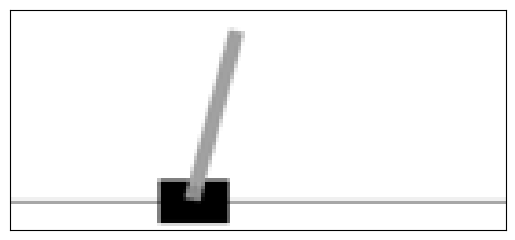

In [4]:
dataset = ImageFolder("Spyketorch_Training")
sample_idx = random.randint(0, len(dataset) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[sample_idx][0])
plt.show()


In [5]:
dataset = ImageFolder("saved_images", transform)
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.50*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
#print("Size of the training set:", len(train_indices))
#print("Size of the  testing set:", len(test_indices))
dataset = CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

In [6]:
pool = Pooling(kernel_size = 3, stride = 2)
conv = Convolution(in_channels=4, out_channels=1, kernel_size=10)
stdp = STDP(conv_layer = conv, learning_rate = (0.05, -0.015))
anti_stdp = STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

In [7]:
feature2class = [0] * 10 + [1] * 10
print(feature2class)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:


print("Starting Reinforcement Learning ...")
for data,targets in train_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            if feature2class[winners[0][0]] == t:  #This checks if there are any winners. If there are, it looks at the top winner (winners[0][0]) and compares its corresponding class from the feature2class dictionary with the target t.
                stdp(x, p, o, winners) # feature match give reward
                    #print('stdp')
            else:
                anti_stdp(x, p, o, winners) # feature didn't match give punishment
                    #print(anti_stdp)
print()
print("Reinforcement Learning is Done.")
print("Saving the pretrained model is done.")


Starting Reinforcement Learning ...


: 

In [ ]:
error = 0
silent = 0
total = 0
for data,targets in test_loader:
    for x,t in zip(data, targets):
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

: 